# Just playing with P1902.

# Loading the data

Here we load all the packages that we need, and import the data (pickled by a preprocessing notebook).

## Loading and prepping the packages.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import anndata

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

To create small-image panels for larger figures, we do a bit of extra work.  First, we set some font sizes to 5-7pt, to match the guidelines in *Nature*.

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Matplotlib is kind of ridiculous when it comes to actually setting the size of images correctly.  The following solution is from https://kavigupta.org/2019/05/18/Setting-the-size-of-figures-in-matplotlib/.  At least it's close to correct!

In [4]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

The following can be useful to check that Helvetica fonts are being used.

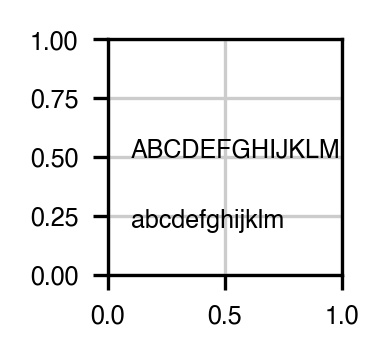

In [5]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

## Loading the data

Here we load the expression matrices and protein data.

In [11]:
experiment = 'P1902'
file_prefix = '../Data/Processed/'
file_suffix = '.loom'  
ds = 'invitro'
adata = anndata.read_loom(file_prefix+experiment+'_'+ds+file_suffix)
adata.var_names = adata.var['gene_name']
adata.obs_names = adata.obs['obs_names']

/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


We extract lists of genes, cells, and bulks.  We custom-make the list of clones, to choose their order.

In [13]:
genes = list(adata.var_names)  # The names of the genes. 
cells = list(adata.obs_names) # The names of the cells.


clones = ['H2', 'B4', 'A7', 'G6', 'A8', 'G8', 'H9', 'F3', 'E4'] 
print(clones) # Convenient reordering of clones, MEM then A7 then EFF then E4.


['H2', 'B4', 'A7', 'G6', 'A8', 'G8', 'H9', 'F3', 'E4']


We place this data into new dataframes called X and y, to follow the machine-learning tradition.  X is the feature matrix (gene expressions of each cell) and y has the classes (clonality of each cell).  For permutation tests, we also create a shuffled version of y, with shuffled clone-labels.

In [14]:
X = adata.to_df().copy()  # The features.  Copied in memory, just in case.
y = adata.obs.Clone_ID # We are trying to predict clonality from the features.
yshuff = pd.Series(np.random.permutation(y.values), index=y.index, name='Clone_ID')

In [15]:
X.head()

gene_name,WASH7P,MTND2P28,hsa-mir-6723,RP5-857K21.7,MTATP8P1,MTATP6P1,RP5-857K21.11,NOC2L,ISG15,RP11-465B22.3,...,TTTY15,USP9Y,DDX3Y,UTY,PSMA6P1,BCORP1,TXLNG2P,KDM5D,EIF1AY,PARP4P1
obs_names,,,,,,,,,,,,,,,,,,,,,
P1902_1289,2.931270,2.828446,1.306369,1.108808,0.0,5.781861,0.000000,0.0,6.884389,0.0,...,0.000000,0.0,0.723545,0.000000,0.0,0.0,0.000000,0.000000,2.792418,0.0
P1902_1290,2.942367,3.935502,0.582051,1.520247,0.0,6.983011,0.000000,0.0,7.427882,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
P1902_1291,0.000000,2.749674,2.199153,1.435323,0.0,5.473203,0.000000,0.0,5.469848,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.766035,0.0
P1902_1293,0.000000,2.940170,2.524608,1.357742,0.0,6.438704,1.029623,0.0,6.994714,0.0,...,0.000000,0.0,0.000000,5.174044,0.0,0.0,0.000000,1.790815,0.000000,0.0
P1902_1294,0.000000,3.788688,0.582189,1.520491,0.0,6.821553,0.000000,0.0,7.290811,0.0,...,5.536519,0.0,0.000000,5.595412,0.0,0.0,5.759866,0.000000,0.000000,0.0


# Time to play

In [279]:
X_bin = (X > 0)
N = len(X_bin)
N

353

In [280]:
oo_modifier = X_bin.sum() / N
oo_modifier = 4*oo_modifier * (1 - oo_modifier)
oo_modifier

gene_name
WASH7P          0.791981
MTND2P28        0.375318
hsa-mir-6723    0.223804
RP5-857K21.7    0.936433
MTATP8P1        0.701073
                  ...   
BCORP1          0.193565
TXLNG2P         0.615108
KDM5D           0.742868
EIF1AY          0.992288
PARP4P1         0.263223
Length: 9118, dtype: float64

In [281]:
bin_genes = oo_modifier[oo_modifier > 0.5].index
X_test = X_bin[bin_genes].copy().astype(int)
X_test

gene_name,WASH7P,RP5-857K21.7,MTATP8P1,RP5-857K21.11,ISG15,TNFRSF18,SDF4,UBE2J2,AURKAIP1,CCNL2,...,SRIP3,PRKY,RNA5-8SP6,TTTY15,USP9Y,DDX3Y,PSMA6P1,TXLNG2P,KDM5D,EIF1AY
obs_names,,,,,,,,,,,,,,,,,,,,,
P1902_1289,1,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
P1902_1290,1,1,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
P1902_1291,0,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
P1902_1293,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
P1902_1294,0,1,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P1902_1665,1,1,0,0,1,1,0,1,0,0,...,1,0,0,1,1,1,0,0,0,0
P1902_1669,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,1,1
P1902_1670,0,1,1,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1


In [282]:
AND_matrix = np.tensordot(X_test.T, X_test, axes=1)
OR_matrix = (N - np.tensordot(1 - X_test.T, 1 - X_test, axes=1))

In [283]:
AND_matrix

array([[ 96,  60,  22, ...,  16,  29,  65],
       [ 60, 221,  56, ...,  43,  47, 120],
       [ 22,  56,  80, ...,  17,  19,  42],
       ...,
       [ 16,  43,  17, ...,  67,  17,  39],
       [ 29,  47,  19, ...,  17,  87,  57],
       [ 65, 120,  42, ...,  39,  57, 192]])

In [284]:
OR_matrix

array([[ 96, 257, 154, ..., 147, 154, 223],
       [257, 221, 245, ..., 245, 261, 293],
       [154, 245,  80, ..., 130, 148, 230],
       ...,
       [147, 245, 130, ...,  67, 137, 220],
       [154, 261, 148, ..., 137,  87, 222],
       [223, 293, 230, ..., 220, 222, 192]], dtype=int64)

In [285]:
Jaccard = pd.DataFrame((AND_matrix / OR_matrix), index=X_test.columns, columns=X_test.columns)
Jaccard

gene_name,WASH7P,RP5-857K21.7,MTATP8P1,RP5-857K21.11,ISG15,TNFRSF18,SDF4,UBE2J2,AURKAIP1,CCNL2,...,SRIP3,PRKY,RNA5-8SP6,TTTY15,USP9Y,DDX3Y,PSMA6P1,TXLNG2P,KDM5D,EIF1AY
gene_name,,,,,,,,,,,,,,,,,,,,,
WASH7P,1.000000,0.233463,0.142857,0.201117,0.274074,0.196262,0.145695,0.186207,0.205000,0.201220,...,0.217617,0.062069,0.191781,0.115646,0.125000,0.191011,0.143791,0.108844,0.188312,0.291480
RP5-857K21.7,0.233463,1.000000,0.228571,0.278195,0.522727,0.365591,0.159533,0.192771,0.340659,0.272727,...,0.374046,0.152893,0.163424,0.165323,0.171429,0.238971,0.214575,0.175510,0.180077,0.409556
MTATP8P1,0.142857,0.228571,1.000000,0.191617,0.223881,0.148325,0.097902,0.130435,0.184211,0.124224,...,0.158730,0.104000,0.112676,0.112782,0.114504,0.139535,0.195489,0.130769,0.128378,0.182609
RP5-857K21.11,0.201117,0.278195,0.191617,1.000000,0.315412,0.279817,0.195122,0.167665,0.257143,0.189189,...,0.277228,0.134615,0.179641,0.147239,0.156250,0.186869,0.164706,0.169811,0.190751,0.317797
ISG15,0.274074,0.522727,0.223881,0.315412,1.000000,0.378378,0.181818,0.227273,0.378947,0.241993,...,0.329897,0.154717,0.185455,0.179104,0.180451,0.323636,0.193431,0.188679,0.222628,0.452145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DDX3Y,0.191011,0.238971,0.139535,0.186869,0.323636,0.266055,0.176829,0.163636,0.236967,0.232955,...,0.191589,0.152318,0.182927,0.157233,0.159236,1.000000,0.160714,0.180645,0.187135,0.294118
PSMA6P1,0.143791,0.214575,0.195489,0.164706,0.193431,0.207071,0.130435,0.131387,0.166667,0.161290,...,0.165775,0.087302,0.113475,0.130769,0.090226,0.160714,1.000000,0.097744,0.152778,0.188596
TXLNG2P,0.108844,0.175510,0.130769,0.169811,0.188679,0.158163,0.170732,0.162602,0.191011,0.150685,...,0.144444,0.146789,0.141732,0.125000,0.108333,0.180645,0.097744,1.000000,0.124088,0.177273


In [286]:
Jcorr = Jaccard * (1 - np.eye(len(Jaccard)))
Jcorr

gene_name,WASH7P,RP5-857K21.7,MTATP8P1,RP5-857K21.11,ISG15,TNFRSF18,SDF4,UBE2J2,AURKAIP1,CCNL2,...,SRIP3,PRKY,RNA5-8SP6,TTTY15,USP9Y,DDX3Y,PSMA6P1,TXLNG2P,KDM5D,EIF1AY
gene_name,,,,,,,,,,,,,,,,,,,,,
WASH7P,0.000000,0.233463,0.142857,0.201117,0.274074,0.196262,0.145695,0.186207,0.205000,0.201220,...,0.217617,0.062069,0.191781,0.115646,0.125000,0.191011,0.143791,0.108844,0.188312,0.291480
RP5-857K21.7,0.233463,0.000000,0.228571,0.278195,0.522727,0.365591,0.159533,0.192771,0.340659,0.272727,...,0.374046,0.152893,0.163424,0.165323,0.171429,0.238971,0.214575,0.175510,0.180077,0.409556
MTATP8P1,0.142857,0.228571,0.000000,0.191617,0.223881,0.148325,0.097902,0.130435,0.184211,0.124224,...,0.158730,0.104000,0.112676,0.112782,0.114504,0.139535,0.195489,0.130769,0.128378,0.182609
RP5-857K21.11,0.201117,0.278195,0.191617,0.000000,0.315412,0.279817,0.195122,0.167665,0.257143,0.189189,...,0.277228,0.134615,0.179641,0.147239,0.156250,0.186869,0.164706,0.169811,0.190751,0.317797
ISG15,0.274074,0.522727,0.223881,0.315412,0.000000,0.378378,0.181818,0.227273,0.378947,0.241993,...,0.329897,0.154717,0.185455,0.179104,0.180451,0.323636,0.193431,0.188679,0.222628,0.452145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DDX3Y,0.191011,0.238971,0.139535,0.186869,0.323636,0.266055,0.176829,0.163636,0.236967,0.232955,...,0.191589,0.152318,0.182927,0.157233,0.159236,0.000000,0.160714,0.180645,0.187135,0.294118
PSMA6P1,0.143791,0.214575,0.195489,0.164706,0.193431,0.207071,0.130435,0.131387,0.166667,0.161290,...,0.165775,0.087302,0.113475,0.130769,0.090226,0.160714,0.000000,0.097744,0.152778,0.188596
TXLNG2P,0.108844,0.175510,0.130769,0.169811,0.188679,0.158163,0.170732,0.162602,0.191011,0.150685,...,0.144444,0.146789,0.141732,0.125000,0.108333,0.180645,0.097744,0.000000,0.124088,0.177273


In [287]:
oo_modifier = oo_modifier.loc[Jcorr.index]
Jcorr = Jcorr.multiply(oo_modifier, axis=1).multiply(oo_modifier, axis=0)
Jcorr

gene_name,WASH7P,RP5-857K21.7,MTATP8P1,RP5-857K21.11,ISG15,TNFRSF18,SDF4,UBE2J2,AURKAIP1,CCNL2,...,SRIP3,PRKY,RNA5-8SP6,TTTY15,USP9Y,DDX3Y,PSMA6P1,TXLNG2P,KDM5D,EIF1AY
gene_name,,,,,,,,,,,,,,,,,,,,,
WASH7P,0.000000,0.173145,0.079320,0.142376,0.181441,0.154077,0.078717,0.099659,0.157185,0.130202,...,0.164568,0.026999,0.104582,0.056978,0.060195,0.133503,0.079129,0.053024,0.110791,0.229066
RP5-857K21.7,0.173145,0.000000,0.150059,0.232863,0.409170,0.339360,0.101915,0.121990,0.308844,0.208659,...,0.334457,0.078636,0.105373,0.096310,0.097610,0.197487,0.139619,0.101095,0.125270,0.380564
MTATP8P1,0.079320,0.150059,0.000000,0.120080,0.131199,0.103078,0.046824,0.061796,0.125032,0.071154,...,0.106258,0.040046,0.054392,0.049189,0.048811,0.086330,0.095230,0.056392,0.066860,0.127035
RP5-857K21.11,0.142376,0.232863,0.120080,0.000000,0.235670,0.247933,0.118984,0.101279,0.222531,0.138166,...,0.236619,0.066089,0.110565,0.081877,0.084924,0.147410,0.102299,0.093367,0.126664,0.281877
ISG15,0.181441,0.409170,0.131199,0.235670,0.000000,0.313520,0.103681,0.128382,0.306671,0.165267,...,0.263311,0.071031,0.106740,0.093137,0.091717,0.238740,0.112348,0.097012,0.138243,0.375031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DDX3Y,0.133503,0.197487,0.086330,0.147410,0.238740,0.232743,0.106459,0.097589,0.202463,0.167966,...,0.161446,0.073829,0.111156,0.086323,0.085446,0.000000,0.098551,0.098061,0.122682,0.257558
PSMA6P1,0.079129,0.139619,0.095230,0.102299,0.112348,0.142625,0.061829,0.061694,0.112119,0.091565,...,0.109989,0.033317,0.054291,0.056527,0.038120,0.098551,0.000000,0.041776,0.078861,0.130035
TXLNG2P,0.053024,0.101095,0.056392,0.093367,0.097012,0.096437,0.071643,0.067590,0.113750,0.075728,...,0.084838,0.049591,0.060029,0.047833,0.040518,0.098061,0.041776,0.000000,0.056701,0.108201


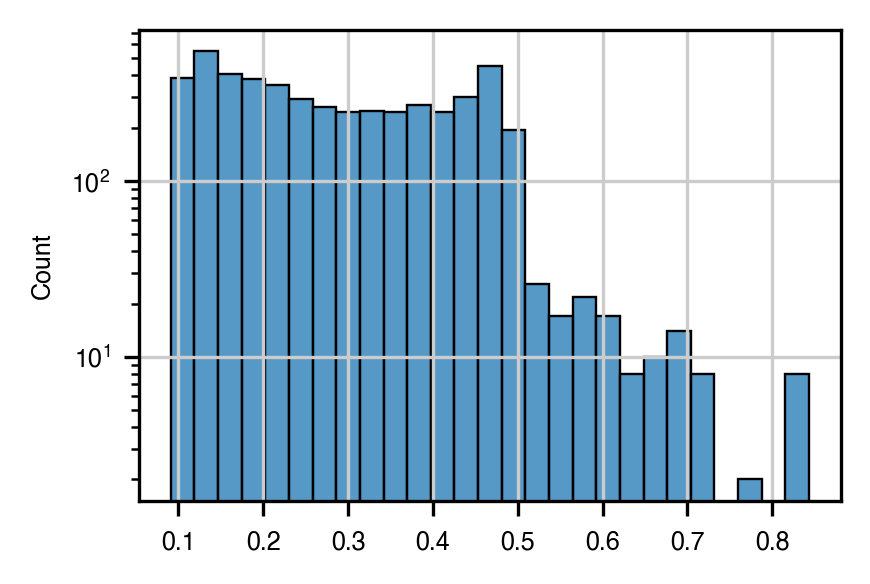

In [288]:
fig,ax = plt.subplots(1,1,figsize=(3,2),dpi=300)
sns.histplot(Jcorr.max())
plt.yscale('log')
plt.show()

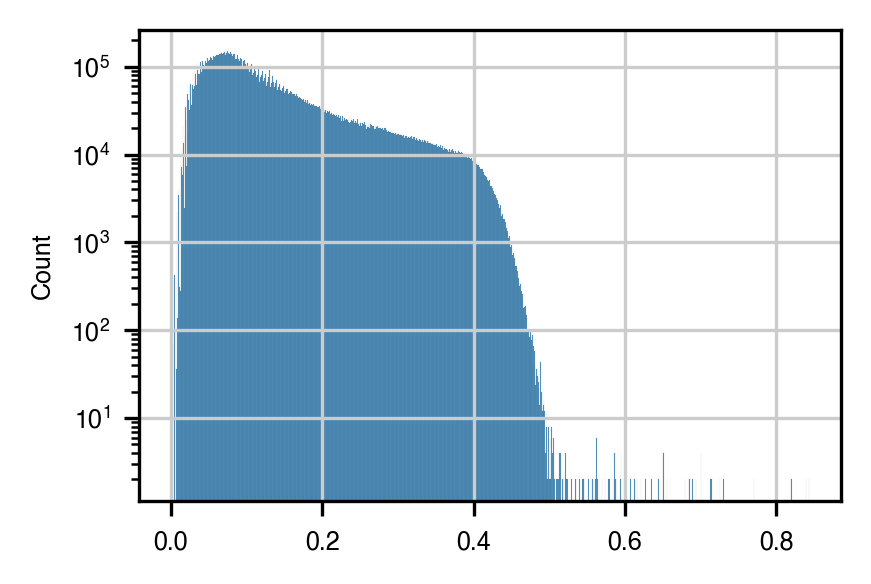

In [289]:
fig,ax = plt.subplots(1,1,figsize=(3,2),dpi=300)
sns.histplot(Jcorr.values.flatten())
plt.yscale('log')
plt.show()

In [296]:
corr_genes = ((Jcorr > 0.45).sum() > 0)
corr_genes = corr_genes[corr_genes].index
corr_genes

Index(['RP5-857K21.7', 'ISG15', 'MRPL20', 'RER1', 'KCNAB2', 'RPL22',
       'TNFRSF1B', 'CHCHD2P6', 'RP11-169K16.7', 'RP11-169K16.8',
       ...
       'STAG2', 'SH2D1A', 'SASH3', 'RAP2C', 'RBMX', 'IDS-2', 'CXorf40B-1',
       'BCAP31-1', 'FLNA-1', 'EIF1AY'],
      dtype='object', name='gene_name', length=818)

In [297]:
cg_df = Jcorr.loc[corr_genes,corr_genes]

In [298]:
cg_df

gene_name,RP5-857K21.7,ISG15,MRPL20,RER1,KCNAB2,RPL22,TNFRSF1B,CHCHD2P6,RP11-169K16.7,RP11-169K16.8,...,STAG2,SH2D1A,SASH3,RAP2C,RBMX,IDS-2,CXorf40B-1,BCAP31-1,FLNA-1,EIF1AY
gene_name,,,,,,,,,,,,,,,,,,,,,
RP5-857K21.7,0.000000,0.409170,0.369271,0.352537,0.354411,0.383352,0.402695,0.297314,0.361358,0.411457,...,0.351221,0.394205,0.377005,0.393207,0.398525,0.339906,0.340093,0.363438,0.419893,0.380564
ISG15,0.409170,0.000000,0.374980,0.387740,0.382038,0.400766,0.407614,0.281285,0.339862,0.403661,...,0.373960,0.391130,0.392773,0.327778,0.379474,0.371148,0.373277,0.373725,0.402981,0.375031
MRPL20,0.369271,0.374980,0.000000,0.401285,0.349972,0.439091,0.415773,0.298592,0.395892,0.436453,...,0.351905,0.379901,0.415407,0.342156,0.364898,0.348968,0.426031,0.381859,0.381229,0.397644
RER1,0.352537,0.387740,0.401285,0.000000,0.388849,0.423530,0.386993,0.322293,0.380999,0.396676,...,0.384872,0.367975,0.421281,0.349372,0.403932,0.371267,0.335499,0.362357,0.387129,0.398894
KCNAB2,0.354411,0.382038,0.349972,0.388849,0.000000,0.374431,0.370107,0.329333,0.340925,0.360677,...,0.371284,0.370394,0.403690,0.315960,0.347225,0.352743,0.373866,0.369644,0.434671,0.428572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IDS-2,0.339906,0.371148,0.348968,0.371267,0.352743,0.397692,0.401663,0.287344,0.335147,0.391987,...,0.401182,0.356007,0.431492,0.386247,0.386448,0.000000,0.388250,0.357840,0.387316,0.404360
CXorf40B-1,0.340093,0.373277,0.426031,0.335499,0.373866,0.442379,0.423902,0.306289,0.393341,0.403488,...,0.370151,0.378223,0.402937,0.344667,0.350621,0.388250,0.000000,0.384766,0.403550,0.384690
BCAP31-1,0.363438,0.373725,0.381859,0.362357,0.369644,0.359545,0.429644,0.313155,0.411205,0.379673,...,0.366053,0.350299,0.388670,0.325817,0.384891,0.357840,0.384766,0.000000,0.424378,0.390898


In [299]:
delta = 1 - (np.eye(len(cg_df)) + cg_df)
delta

gene_name,RP5-857K21.7,ISG15,MRPL20,RER1,KCNAB2,RPL22,TNFRSF1B,CHCHD2P6,RP11-169K16.7,RP11-169K16.8,...,STAG2,SH2D1A,SASH3,RAP2C,RBMX,IDS-2,CXorf40B-1,BCAP31-1,FLNA-1,EIF1AY
gene_name,,,,,,,,,,,,,,,,,,,,,
RP5-857K21.7,0.000000,0.590830,0.630729,0.647463,0.645589,0.616648,0.597305,0.702686,0.638642,0.588543,...,0.648779,0.605795,0.622995,0.606793,0.601475,0.660094,0.659907,0.636562,0.580107,0.619436
ISG15,0.590830,0.000000,0.625020,0.612260,0.617962,0.599234,0.592386,0.718715,0.660138,0.596339,...,0.626040,0.608870,0.607227,0.672222,0.620526,0.628852,0.626723,0.626275,0.597019,0.624969
MRPL20,0.630729,0.625020,0.000000,0.598715,0.650028,0.560909,0.584227,0.701408,0.604108,0.563547,...,0.648095,0.620099,0.584593,0.657844,0.635102,0.651032,0.573969,0.618141,0.618771,0.602356
RER1,0.647463,0.612260,0.598715,0.000000,0.611151,0.576470,0.613007,0.677707,0.619001,0.603324,...,0.615128,0.632025,0.578719,0.650628,0.596068,0.628733,0.664501,0.637643,0.612871,0.601106
KCNAB2,0.645589,0.617962,0.650028,0.611151,0.000000,0.625569,0.629893,0.670667,0.659075,0.639323,...,0.628716,0.629606,0.596310,0.684040,0.652775,0.647257,0.626134,0.630356,0.565329,0.571428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IDS-2,0.660094,0.628852,0.651032,0.628733,0.647257,0.602308,0.598337,0.712656,0.664853,0.608013,...,0.598818,0.643993,0.568508,0.613753,0.613552,0.000000,0.611750,0.642160,0.612684,0.595640
CXorf40B-1,0.659907,0.626723,0.573969,0.664501,0.626134,0.557621,0.576098,0.693711,0.606659,0.596512,...,0.629849,0.621777,0.597063,0.655333,0.649379,0.611750,0.000000,0.615234,0.596450,0.615310
BCAP31-1,0.636562,0.626275,0.618141,0.637643,0.630356,0.640455,0.570356,0.686845,0.588795,0.620327,...,0.633947,0.649701,0.611330,0.674183,0.615109,0.642160,0.615234,0.000000,0.575622,0.609102


gene_name
RP5-857K21.7    0.451082
ISG15           0.466263
MRPL20          0.451580
RER1            0.472216
KCNAB2          0.450794
                  ...   
IDS-2           0.467012
CXorf40B-1      0.472149
BCAP31-1        0.453266
FLNA-1          0.463747
EIF1AY          0.493265
Length: 818, dtype: float64

In [340]:
adata.var.F_pval.sort_values()[:30]

gene_name
LRRC28           4.834792e-58
PLS3-1           9.938207e-55
REG4             1.439458e-52
AMICA1           3.562787e-52
AC010970.2       2.151594e-43
KLRC2            1.390487e-42
KLRC3            2.979239e-40
CXCR6            4.639945e-40
KLRD1            9.917434e-39
ANXA1            7.395435e-38
CD2              1.743682e-37
TIMD4            7.323017e-36
IL32             7.817828e-36
GPR15            1.148268e-35
CCL4L1           1.031008e-34
KLRB1            5.382832e-33
MALAT1           5.260718e-32
KLRC1            7.345655e-32
ALOX5AP          1.059799e-30
MIR155HG         3.823799e-29
CCL3L1           5.131802e-29
LAG3             3.328569e-28
SAMD3            1.035375e-27
PLEK             1.590027e-27
LAIR2            1.771598e-27
B2M              4.664117e-27
RP11-217O12.1    1.129989e-26
RP3-477M7.5      6.797417e-26
CD74             9.193979e-26
CCL3L3           1.829916e-25
Name: F_pval, dtype: float64

In [347]:
delta['KLRC1'].sort_values()[:10]

gene_name
KLRC1     0.000000
KLRC2     0.436361
KLRC3     0.437096
VAMP5     0.506250
IFITM2    0.516114
PLSCR1    0.520101
IFITM1    0.520112
KLRD1     0.525485
SDC4      0.528430
HSPB11    0.529392
Name: KLRC1, dtype: float64

In [320]:
delta['VAMP5'].sort_values()[:10]

gene_name
VAMP5     0.000000
IFITM1    0.494020
KLRC1     0.506250
KLRC2     0.511278
CANX      0.515190
IFITM2    0.515407
PPP4C     0.527011
NDUFB9    0.532111
CD82      0.534067
CD48      0.534618
Name: VAMP5, dtype: float64

In [300]:
cg_df.idxmax()

gene_name
RP5-857K21.7     HLA-DMA
ISG15              CASP4
MRPL20            DPYSL2
RER1            TOR1AIP1
KCNAB2             EEF1D
                  ...   
IDS-2              LRRN3
CXorf40B-1          CDK6
BCAP31-1          TM9SF2
FLNA-1             ESYT1
EIF1AY             TCEB1
Length: 818, dtype: object

gene_name
LRRC28        4.834792e-58
PLS3-1        9.938207e-55
REG4          1.439458e-52
AMICA1        3.562787e-52
AC010970.2    2.151594e-43
                  ...     
C1orf50       9.978825e-01
FASTKD3       9.986236e-01
AFG3L1P       9.996278e-01
GCDH          9.997226e-01
HBP1          9.998490e-01
Name: F_pval, Length: 9118, dtype: float64

In [350]:
coord_df

,0,1
gene_name,,
RP5-857K21.7,-19.314095,16.583738
ISG15,-33.176201,2.791169
MRPL20,13.167473,5.900456
RER1,-5.579803,-11.960980
KCNAB2,-17.290823,26.112804
...,...,...
IDS-2,5.911691,-35.684086
CXorf40B-1,0.576443,-19.430105
BCAP31-1,21.332859,-20.120668


In [357]:
tightness = cg_df.max()
tightness.sort_values()

gene_name
PPDPF            0.450341
KPNA6            0.450343
CREM             0.450394
ZC3H4            0.450420
SSB              0.450503
                   ...   
IFITM2           0.819881
PIN4             0.839352
PIN4P1           0.839352
RP11-169K16.7    0.843237
UQCRH            0.843237
Length: 818, dtype: float64

In [360]:
tightness.sort_values()[-30:]

gene_name
NAMPT            0.684549
NAMPTL           0.684549
TMEM167A         0.685714
AC005255.3       0.685714
EEF1D            0.689220
EEF1DP1          0.689220
RAC1P2           0.693806
RAC1             0.693806
PRELID1          0.700583
RP11-543B16.2    0.700583
RP11-421N8.1     0.700647
ATP5F1           0.700647
RPS10            0.713085
RP11-425L10.1    0.713085
FAM3C2           0.714367
FAM3C            0.714367
CDC26            0.725633
RP11-305M3.2     0.725633
ITGB1            0.729901
ITGB1P1          0.729901
KLRC2            0.770207
KLRC3            0.770207
AC007318.5       0.819274
VDAC2            0.819274
IFITM3           0.819881
IFITM2           0.819881
PIN4             0.839352
PIN4P1           0.839352
RP11-169K16.7    0.843237
UQCRH            0.843237
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Text(0.5, 0.98, '818 genes, clustered via tSNE.')

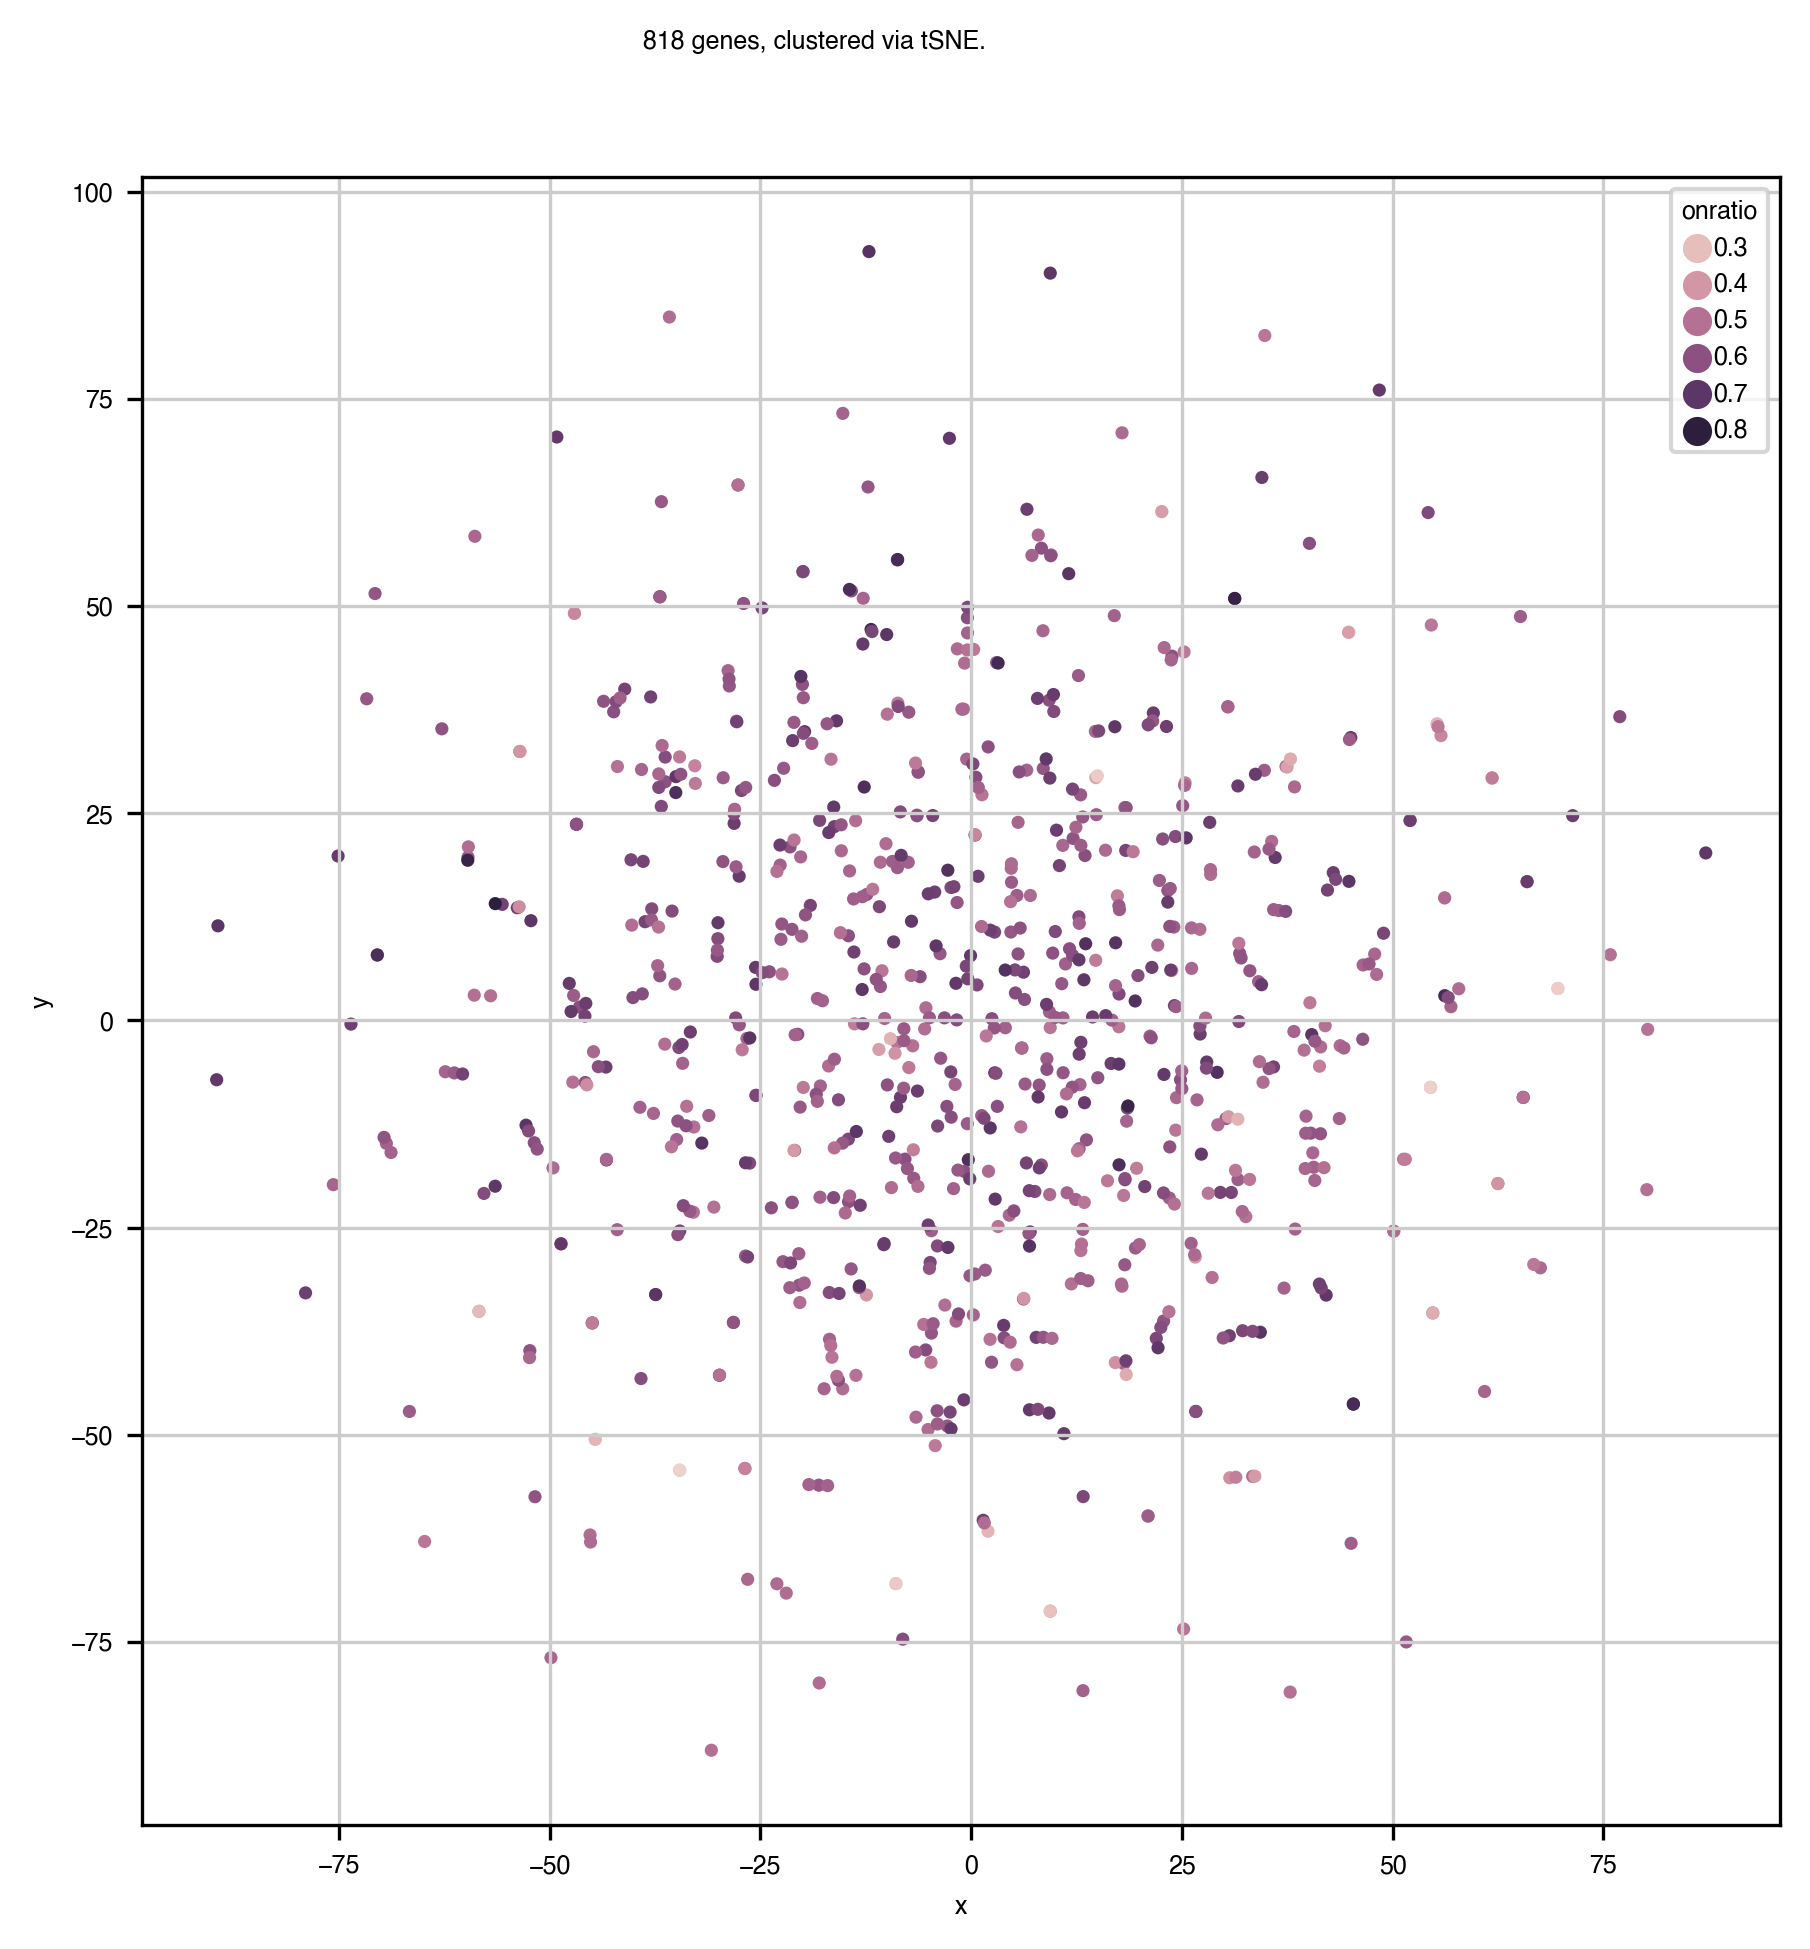

In [379]:
from sklearn.preprocessing import normalize
from sklearn import manifold
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import numpy


model = manifold.TSNE(n_components=2, perplexity=5, random_state=0, 
                      learning_rate=20, metric='precomputed')
coords = model.fit_transform(delta)
coord_df = pd.DataFrame(coords, index=delta.index, columns=['x','y'])
coord_df['gene'] = coord_df.index
coord_df['onratio'] = X_test[delta.index].sum() / len(X_test)

#cmap = plt.get_cmap('Set1')
#colors = [cmap(i) for i in numpy.linspace(0, 1, simulations)]

plt.figure(figsize=(7, 7), dpi=300)
sns.scatterplot(x='x', y='y', hue='onratio', data=coord_df, s=10, edgecolor='None')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    j = 0
    for i, point in a.iterrows():
        j += 1
        offset = 2*((j%2) - 0.5)
        ax.text(point['x'] , point['y'] + offset, str(point['val']))

genes_plot = tightness[(tightness > 0.5) & (tightness < 0.52)].index

coord_df = coord_df.loc[genes_plot]
#label_point(coord_df['x'], coord_df['y'], coord_df['gene'], plt.gca())
plt.suptitle('{} genes, clustered via tSNE.'.format(len(delta.index)))